In [23]:
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Problem to solve  
  
Let an object of mass $m$ in free fall undergoing linear friction in 1 dimension ($Ox$).   
By the fondamental principle of mechanics :  
$$
    m\vec{a} = \vec{P} + \vec{f}
$$
By projecting on the ($Ox$) axis : 
$$
            -mg - kv = ma \\
    \iff    a = - (\frac{k}{m}v + g) \\
    \iff    \frac{d²x}{dt²} = - (\frac{k}{m} \frac{dx}{dt} + g)   
$$
By solving the differential equation, we obtain :   
$$x(t) =  - \frac{m}{k} (v_0 + g \frac{m}{k}) e^{-\frac{kt}{m}} - \frac{gm}{k}t + x_0 $$
$$ v(t) = ( v_0 + \frac{gm}{k})e^{- \frac{kt}{m}} - \frac{gm}{k} $$
  
With a PINN, we'll try to approximate x. In order to keep consistency, we define f(t,x) as : $$f(t,x) := \frac{d²x}{dt²} - ( - \frac{k}{m} \frac{dx}{dt} - g ) =  \frac{d²x}{dt²} + \frac{k}{m} \frac{dx}{dt} + g $$.  
The boundary conditions are $x \in [0, x_0]$ and $t \in [0, T]$.

Our model is data-driven solution and continuous time discrete. As we only have one parameter $t$, we'll have $1$ input and as we'd like to predict $x(t)$ which is $1$ dimension, we have 1 output.

## Function to guess

In [2]:
m = 10 #kg
x_0 = 10000 #meters
v_0 = 0 #m.s⁻1
k = 5

def x(t):
    x = - (m / k) * (v_0 + 9.81 * (m / k)) * torch.exp(- (k * t / m)) - (9.81 * m / k) * t + x_0
    x = torch.where(x > 0, x, 0.)
    return x

def v(t, x):
    v = (v_0 + 9.81 * m / k) * torch.exp(- k * t / m) - 9.81 * m / k
    v = torch.where(x > 0, v, 0.)
    return v

def a(t, v, x):
    a = - 9.81 - k * v / m 
    a = torch.where(x > 0, a, 0.)
    return a


# Definition of the data
t_min = 0
t_max = 100 #s
nof_pts = 10000

t_data = torch.linspace(t_min, t_max, nof_pts)
t_data = t_data.reshape(t_data.shape[0], 1)
x_data = x(t_data)
v_data = v(t_data, x_data)
a_data = a(t_data, v_data, x_data)


## Model

In [3]:
class very_simple_PINN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, nof_hidden_layers):
        super().__init__()

        self.layers = nn.Sequential(nn.Linear(input_size, hidden_size), 
                                    nn.GELU()
                                    )
        for i in range(nof_hidden_layers):
            self.layers.add_module("linear", nn.Linear(hidden_size, hidden_size))
            self.layers.add_module("Gelu", nn.GELU())
                                   
        self.layers.add_module("output_layer", nn.Linear(hidden_size, output_size))

    def forward(self, x):
        return self.layers(x)

## Utils

In [4]:
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable


def plot_data(t_data, data):
    plt.plot(t_data, data)
    plt.show()

def data_loss(x_data, predicted_x_data):
    return nn.MSELoss(x_data, predicted_x_data)

def f(t, network, ground_truth_a_data):
    """
        As the PINN is based on f(t) = - g - k * dx/dt / m 
    """
    predicted_x = network(t)
    dx_dt       = torch.autograd.grad(predicted_x.sum(), t, create_graph=True)[0] 
    return ground_truth_a_data + 9.81 + k * dx_dt / m


def train(model, 
          t_data, ground_truth_x_data, ground_truth_a_data,
          optimizer, nof_iterations, 
          device):

    training_loss = []

    for epoch in range(nof_iterations):

        model.train()

        optimizer.zero_grad()

        t_data = Variable(t_data, requires_grad=True).to(device)

        predicted_x_data = model(t_data)

        # Loss from the data 
        loss = nn.MSELoss()
        data_loss = loss(ground_truth_x_data, predicted_x_data)

        # Physics (consistency) loss
        f_output = f(t_data, model, ground_truth_a_data)

        f_loss = nn.MSELoss()
        physics_loss = f_loss(torch.zeros_like(f_output), f_output)
        
        # Global loss
        running_loss = data_loss + physics_loss 

        training_loss.append(running_loss.item())

        running_loss.backward()
        optimizer.step()

        #with torch.no_grad():
        #    print("Epoch:", epoch, ", training loss:", running_loss.item())

    return training_loss




## Main

In [5]:
from torchsummary import summary

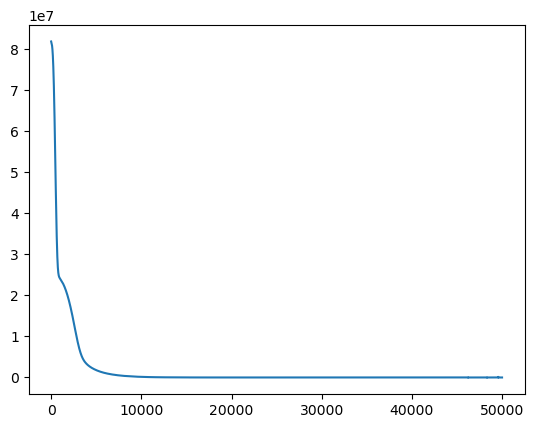

In [6]:
if __name__=="__main__":
    
    #Model
    input_size = 1
    hidden_size = 20
    output_size = 1
    nof_hidden_layers = 1

    PINN_net = very_simple_PINN(input_size, hidden_size, output_size, nof_hidden_layers)
    PINN_net = PINN_net.to(device)
 
    #summary(PINN_net, (10000,1))
    #print(PINN_net.training)

    t_data = t_data
    ground_truth_x_data = x_data
    ground_truth_a_data = a_data
    learning_rate = 0.001
    optimizer = torch.optim.Adam(PINN_net.parameters(), lr=learning_rate) 
    
    nof_iterations = 50000

    training_loss = train(PINN_net, 
                          t_data, ground_truth_x_data, ground_truth_a_data,
                          optimizer, nof_iterations,
                          device)
        
    plt.plot(training_loss)
    plt.show()
     



In [8]:
torch.save(PINN_net.state_dict(), 'first_model.pt')

## Inferences

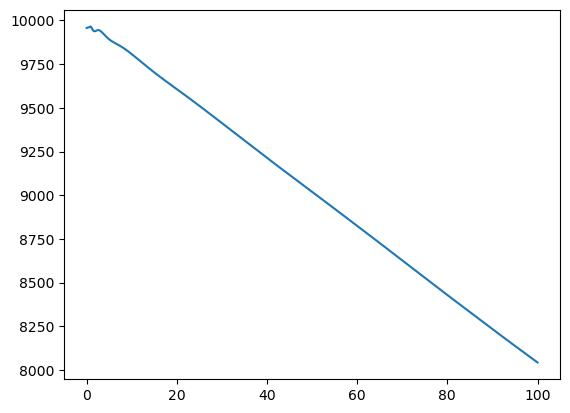

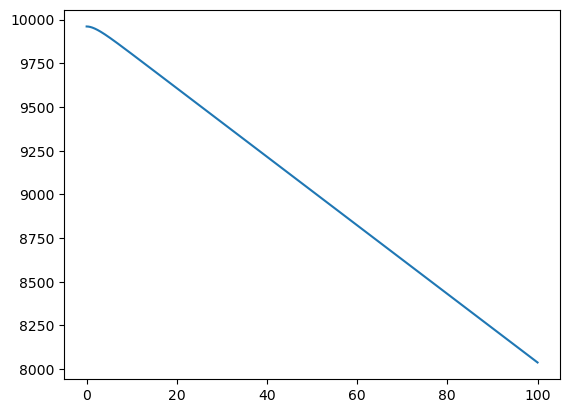

In [34]:
import numpy as np

t = torch.linspace(0, 100, 10000)
t = t.reshape(t.shape[0], 1)

trajectory = PINN_net(t)

trajectory = trajectory.detach().numpy()

plt.plot(np.linspace(0, 100, 10000), trajectory)
plt.show()

plot_data(t_data, x_data)